In [4]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import datetime
import yfinance as yf

In [7]:
# Определяем период времени
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime.now()
'''
Был выбран AAPL из-за более низкой волатильности временного ряда по сравнению с MSFT 
стандартное отклонение AAPL 65.06 против 118.28 MSFT.  
Высокая волатильность MSFT может привести к затруднениям в построении точной модели ARIMA
'''

# оставляем AAPL
tickers = ['AAPL']

# Создаем пустой словарь для хранения данных
data = {}

# Загружаем данные для каждой компании
for ticker in tickers:
    try:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
        print(f"Данные для {ticker} успешно загружены.")
    except Exception as e:
        print(f"Ошибка при загрузке данных для {ticker}: {e}")
        data[ticker] = None  # Помечаем, что данные не загружены

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Данные для AAPL успешно загружены.


In [9]:
# Выводим первые строки для проверки
print("\nПервые строки данных для Apple (AAPL):")
print(data['AAPL'].head())


Первые строки данных для Apple (AAPL):
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2017-01-03  26.862427  26.904056  26.540957  26.781481  115127600
2017-01-04  26.832357  26.945683  26.769914  26.793041   84472400
2017-01-05  26.968813  27.026631  26.783793  26.809234   88774400
2017-01-06  27.269468  27.327287  26.936434  27.008128  127007600
2017-01-09  27.519245  27.621006  27.276409  27.278720  134247600


In [11]:
def adf_test(series, title=''):
    """возвращает отчет ADF"""
    print(f'Тест Дики-Фуллера: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles potential missing values
    labels = ['ADF статистика','p-значение','#Лаги','Количество наблюдений']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'Критическое значение ({key})']=val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("=> Отклоняем нулевую гипотезу")
        print("=> Временной ряд стационарен")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("=> Не отклоняем нулевую гипотезу")
        print("=> Временной ряд не стационарен")


In [13]:
# Преобразуем индекс в datetime и указываем частоту
data['AAPL'].index = pd.to_datetime(data['AAPL'].index)
data['AAPL'] = data['AAPL'].asfreq('D') # 'D' для ежедневной частоты
data['AAPL'] = data['AAPL'].fillna(method='ffill')

# 2. Создаем столбец Close_diff как столбец с одним индексом
data['AAPL']['Close_diff'] = data['AAPL'][('Close', 'AAPL')].diff()
data['AAPL'] = data['AAPL'].dropna()


/tmp/ipykernel_490052/628683402.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['AAPL'] = data['AAPL'].fillna(method='ffill')


In [15]:
# Проверяем стационарность после дифференцирования
adf_test(data['AAPL']['Close_diff'], title='Разность цены закрытия Apple (AAPL)')

Тест Дики-Фуллера: Разность цены закрытия Apple (AAPL)
ADF статистика               -1.499689e+01
p-значение                    1.104317e-27
#Лаги                         1.300000e+01
Количество наблюдений         3.024000e+03
Критическое значение (1%)    -3.432514e+00
Критическое значение (5%)    -2.862496e+00
Критическое значение (10%)   -2.567279e+00
Сильные доказательства против нулевой гипотезы
=> Отклоняем нулевую гипотезу
=> Временной ряд стационарен


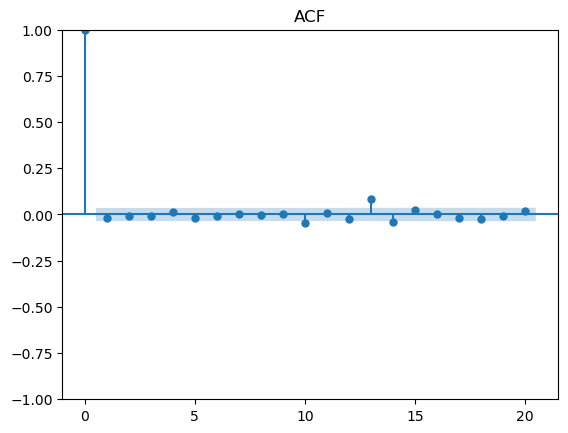

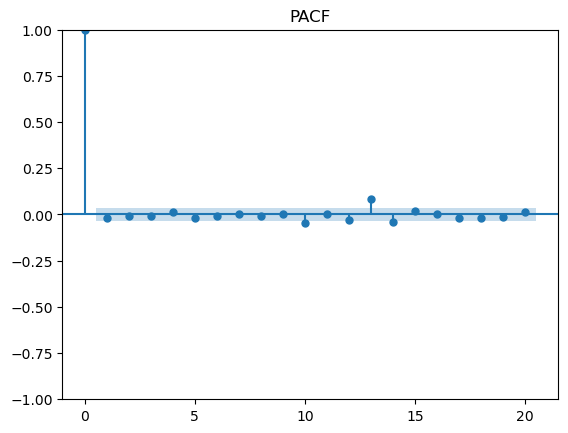

In [17]:
# Графики ACF и PACF для определения p и q
plot_acf(data['AAPL']['Close_diff'], lags=20)
plt.title('ACF')
plt.show()

plot_pacf(data['AAPL']['Close_diff'], lags=20, method="ywm")
plt.title('PACF')
plt.show()


Учитывая, что мы имеем дело с финансовыми данными (цены акций), которые демонстрируют тренды, цикличность, а также некоторую случайность, разумным выбором будет модель ARIMA (Autoregressive Integrated Moving Average).
ARIMA явно моделирует автокорреляцию во временном ряду, то есть зависимость текущего значения от предыдущих значений. Это важно для финансовых данных, где цены часто имеют тенденцию следовать за предыдущими движениями.
ARIMA требует, чтобы временной ряд был стационарным. Мы уже выполнили преобразование временного ряда в стационарный, поэтому ARIMA подходит для наших данных.
ARIMA имеет три параметра (p, d, q), которые позволяют настраивать модель для различных типов временных рядов.
ARIMA - это широко известная и проверенная модель, которая часто используется для прогнозирования финансовых временных рядов.

In [34]:
# Теперь используем 'Close_diff' в качестве стационарного ряда
series = data['AAPL']['Close_diff']

# Параметры ARIMA (p, d, q) - 
p = 0
d = 1
q = 1

# 3. Кросс-валидация с TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
mse_list = []

for train_index, test_index in tscv.split(series):
    X_train, X_test = series.iloc[train_index], series.iloc[test_index]

    # Обучение модели
    model = ARIMA(X_train, order=(p, d, q))
    model_fit = model.fit()

    # Прогнозирование на тестовой выборке
    predictions = model_fit.predict(start=test_index[0], end=test_index[-1])

    # Оценка качества прогноза
    mse = mean_squared_error(X_test, predictions)
    mse_list.append(mse)
    print(f"MSE для разбиения: {mse}")

print("Средняя MSE:", np.mean(mse_list))

MSE для разбиения: 0.48441803965896973
MSE для разбиения: 3.8517938541303813
MSE для разбиения: 4.883505294387909
MSE для разбиения: 4.690036867710551
MSE для разбиения: 9.909000724386143
Средняя MSE: 4.763750956054791


 MSE для каждого разбиения кросс-валидации и средняя MSE

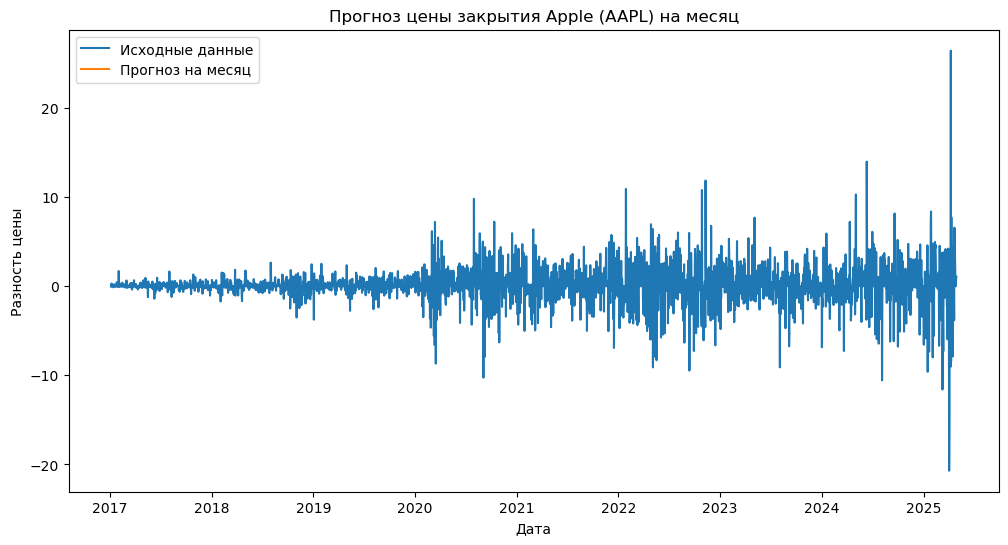

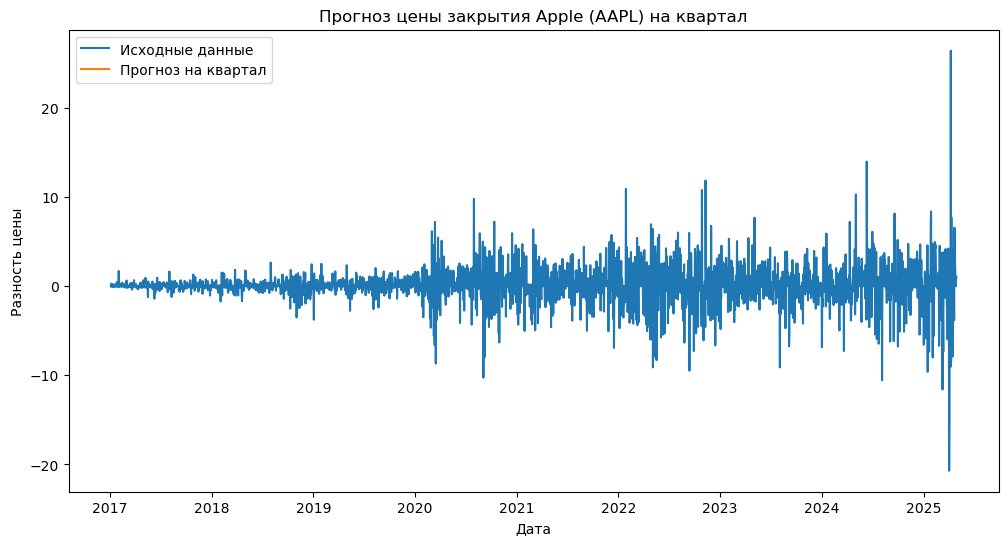

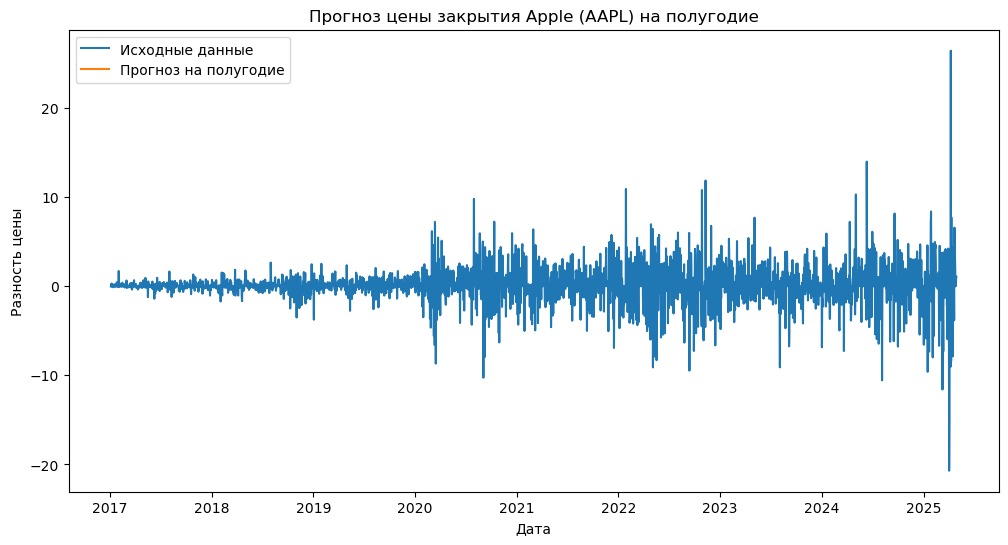

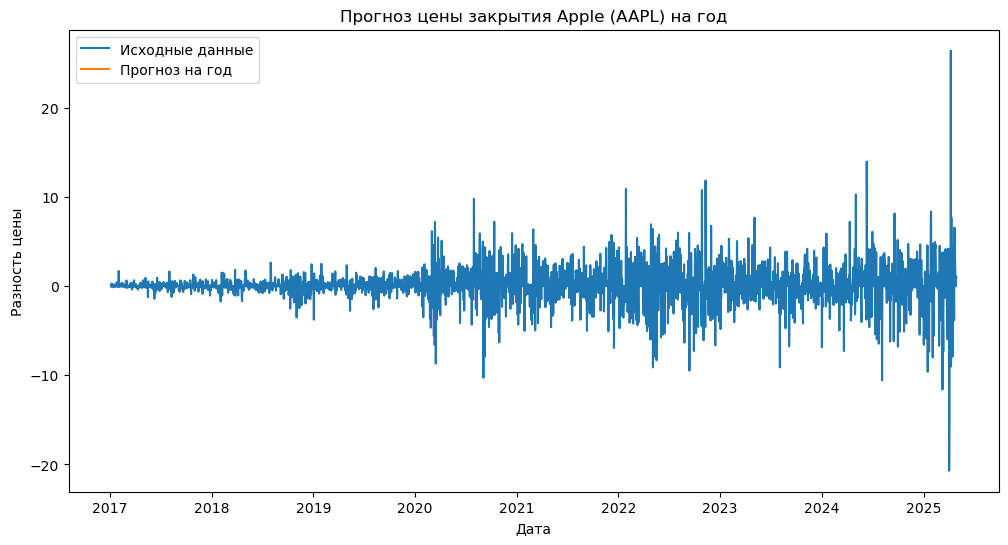

In [36]:
# Прогнозирование на будущее (после кросс-валидации)

# # Обучение модели на всем датасете
# model = ARIMA(series, order=(p, d, q))
# model_fit = model.fit()

# Определяем горизонты прогнозирования в днях
horizons = {
    'месяц': 30,
    'квартал': 90,
    'полугодие': 180,
    'год': 365
}
# Для каждого горизонта делаем прогноз
for period_name, period_length in horizons.items():
    # Прогнозирование
    forecast = model_fit.forecast(steps=period_length)

    # Визуализируем результаты
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Исходные данные')

    # Генерируем даты для прогноза
    last_date = series.index[-1]
    forecast_dates = [last_date + datetime.timedelta(days=i) for i in range(1, period_length + 1)]

    # Преобразуем forecast_dates в индекс DataFrame
    forecast_series = pd.Series(forecast, index=forecast_dates)

    # Рисуем прогноз
    plt.plot(forecast_series, label=f'Прогноз на {period_name}')
    plt.title(f'Прогноз цены закрытия Apple (AAPL) на {period_name}')
    plt.xlabel('Дата')
    plt.ylabel('Разность цены')
    plt.legend()
    plt.show()

In [38]:

# Теперь используем 'Close_diff' в качестве стационарного ряда
series = data['AAPL']['Close_diff']

# Разделение данных на обучающую и тестовую выборки (TimeSeriesSplit)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

#  разделение данных (используем только первое разбиение)
for train_index, test_index in tscv.split(series):
    X_train, X_test = series.iloc[train_index], series.iloc[test_index]
    break # Берем только первое разбиение

# Параметры ARIMA (p, d, q) 
# мы выполнили дифференцирование один раз: d = 1
p = 0
d = 1
q = 1

# Обучение модели ARIMA
model = ARIMA(X_train, order=(p, d, q))
model_fit = model.fit()

# Вывод сводки по модели
print(model_fit.summary())

# Прогнозирование на тестовой выборке
predictions = model_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1) #  X_test.index) -  если нужно указать индексы

# Оценка качества прогноза
mse = mean_squared_error(X_test, predictions)
print(f'MSE: {mse}')



                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                  508
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -260.032
Date:                Wed, 30 Apr 2025   AIC                            524.064
Time:                        09:09:20   BIC                            532.521
Sample:                    01-04-2017   HQIC                           527.380
                         - 05-26-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      4.346     -0.230      0.818      -9.518       7.518
sigma2         0.1613      0.701      0.230      0.818      -1.214       1.536
Ljung-Box (L1) (Q):                   0.44   Jarque-

In [40]:
'''
пробовала разные, остановилась на  ARIMA(0, 1, 1), так как  
является предпочтительной моделью, она проще, имеет лучшие значения информационных критериев (AIC, BIC, HQIC) 
и успешно устраняет автокорреляцию остатков
'''

'\nпробовала разные, остановилась на  ARIMA(0, 1, 1), так как  \nявляется предпочтительной моделью, она проще, имеет лучшие значения информационных критериев (AIC, BIC, HQIC) \nи успешно устраняет автокорреляцию остатков\n'

MSE для разбиения: 0.48441803965896973
MSE для разбиения: 3.8517938541303813
MSE для разбиения: 4.883505294387909
MSE для разбиения: 4.690036867710551
MSE для разбиения: 9.909000724386143
Средняя MSE: 4.763750956054791


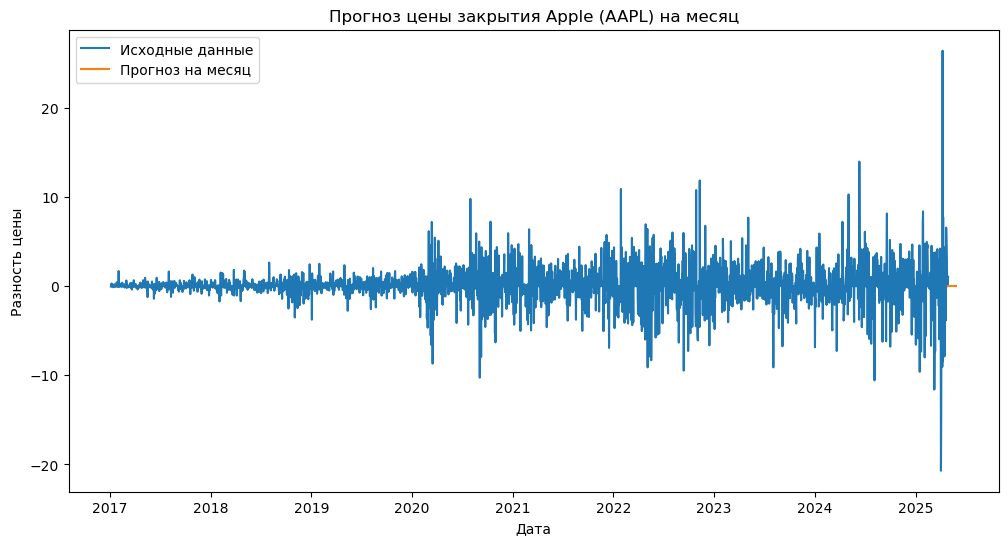

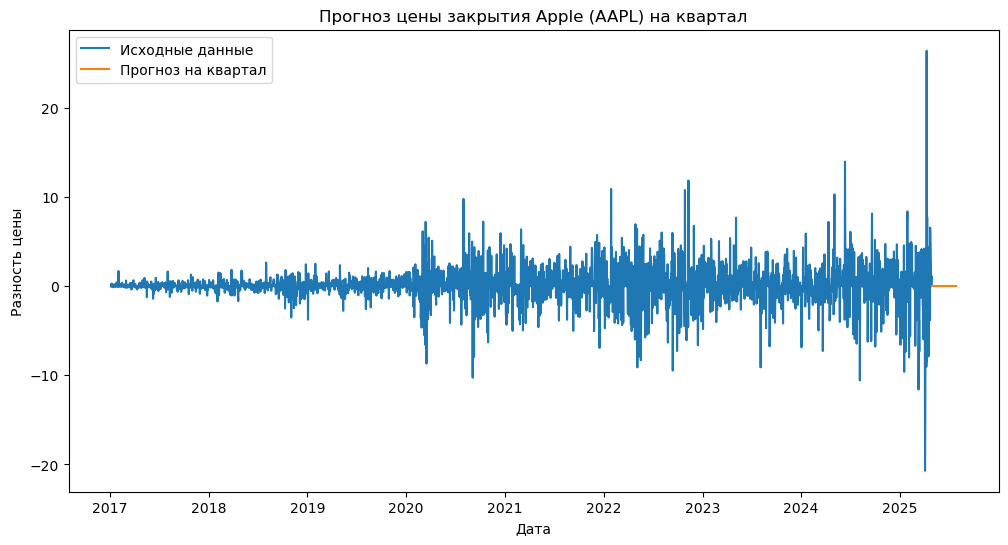

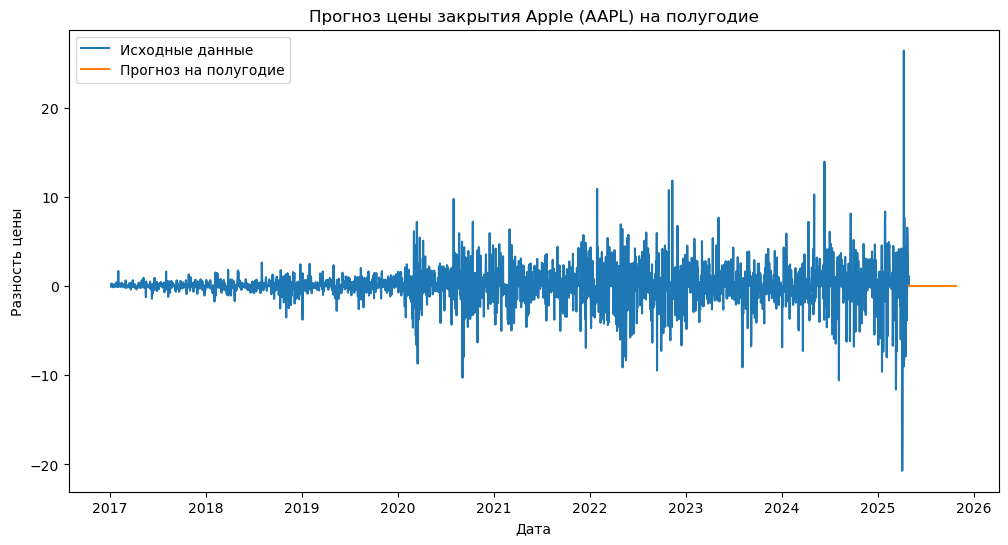

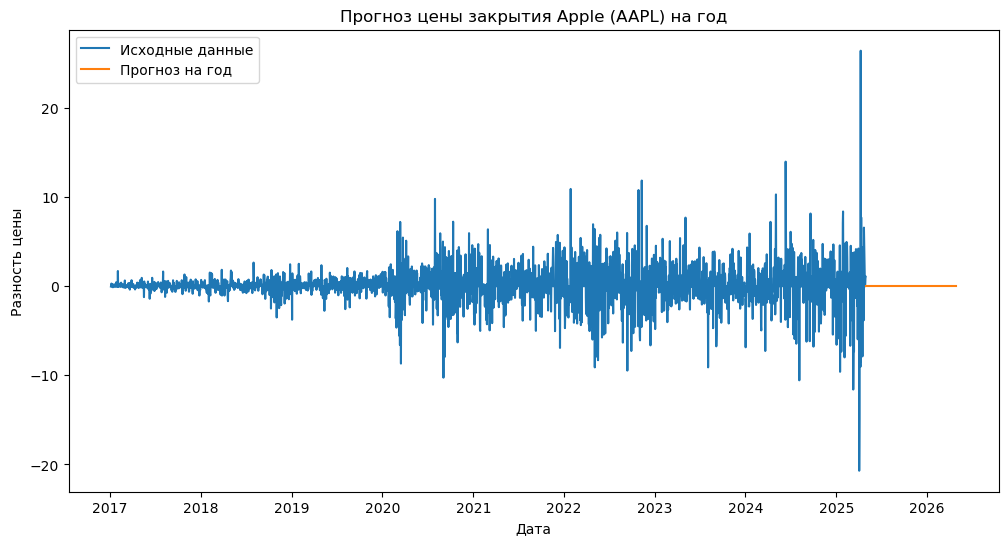

In [42]:
# Подготовка данных 
series = data['AAPL']['Close_diff']

# Параметры ARIMA
p = 0
d = 1
q = 1

# Кросс-валидация с TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
mse_list = []

for train_index, test_index in tscv.split(series):
    X_train, X_test = series.iloc[train_index], series.iloc[test_index]

    # Обучение модели
    model = ARIMA(X_train, order=(p, d, q))
    model_fit = model.fit()

    # Прогнозирование на тестовой выборке
    predictions = model_fit.predict(start=test_index[0], end=test_index[-1])

    # Оценка качества прогноза
    mse = mean_squared_error(X_test, predictions)
    mse_list.append(mse)
    print(f"MSE для разбиения: {mse}")

print("Средняя MSE:", np.mean(mse_list))

# Прогнозирование на будущее (после кросс-валидации)

# Обучение модели на всем датасете
model = ARIMA(series, order=(p, d, q))
model_fit = model.fit()

# Определяем горизонты прогнозирования в днях
horizons = {
    'месяц': 30,
    'квартал': 90,
    'полугодие': 180,
    'год': 365
}

# Для каждого горизонта делаем прогноз
for period_name, period_length in horizons.items():
    # Прогнозирование
    forecast = model_fit.forecast(steps=period_length)

    # Визуализируем результаты
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Исходные данные')

    # Генерируем даты для прогноза
    last_date = series.index[-1]
    forecast_dates = [last_date + datetime.timedelta(days=i) for i in range(1, period_length + 1)]

    # Преобразуем forecast_dates в индекс DataFrame
    forecast_series = pd.Series(forecast, index=forecast_dates)

    # Рисуем прогноз
    plt.plot(forecast_series, label=f'Прогноз на {period_name}')
    plt.title(f'Прогноз цены закрытия Apple (AAPL) на {period_name}')
    plt.xlabel('Дата')
    plt.ylabel('Разность цены')
    plt.legend()
    plt.show()

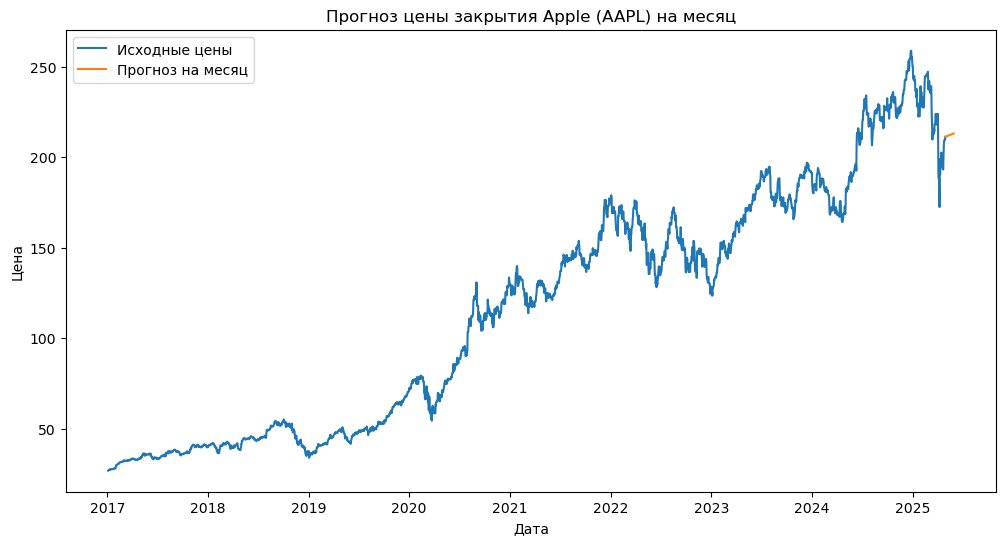

Прогноз цены закрытия Apple (AAPL) на месяц:
2025-04-30    211.270607
2025-05-01    211.331207
2025-05-02    211.391807
2025-05-03    211.452408
2025-05-04    211.513008
2025-05-05    211.573608
2025-05-06    211.634208
2025-05-07    211.694809
2025-05-08    211.755409
2025-05-09    211.816009
2025-05-10    211.876609
2025-05-11    211.937209
2025-05-12    211.997810
2025-05-13    212.058410
2025-05-14    212.119010
2025-05-15    212.179610
2025-05-16    212.240211
2025-05-17    212.300811
2025-05-18    212.361411
2025-05-19    212.422011
2025-05-20    212.482611
2025-05-21    212.543212
2025-05-22    212.603812
2025-05-23    212.664412
2025-05-24    212.725012
2025-05-25    212.785613
2025-05-26    212.846213
2025-05-27    212.906813
2025-05-28    212.967413
2025-05-29    213.028014
Name: predicted_mean, dtype: float64


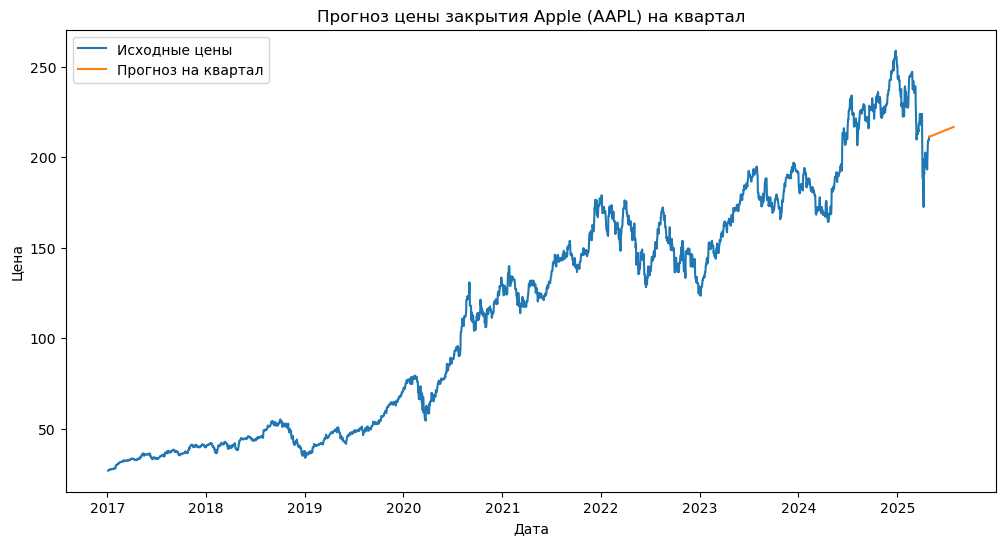

Прогноз цены закрытия Apple (AAPL) на квартал:
2025-04-30    211.270607
2025-05-01    211.331207
2025-05-02    211.391807
2025-05-03    211.452408
2025-05-04    211.513008
                 ...    
2025-07-24    216.421626
2025-07-25    216.482226
2025-07-26    216.542827
2025-07-27    216.603427
2025-07-28    216.664027
Name: predicted_mean, Length: 90, dtype: float64


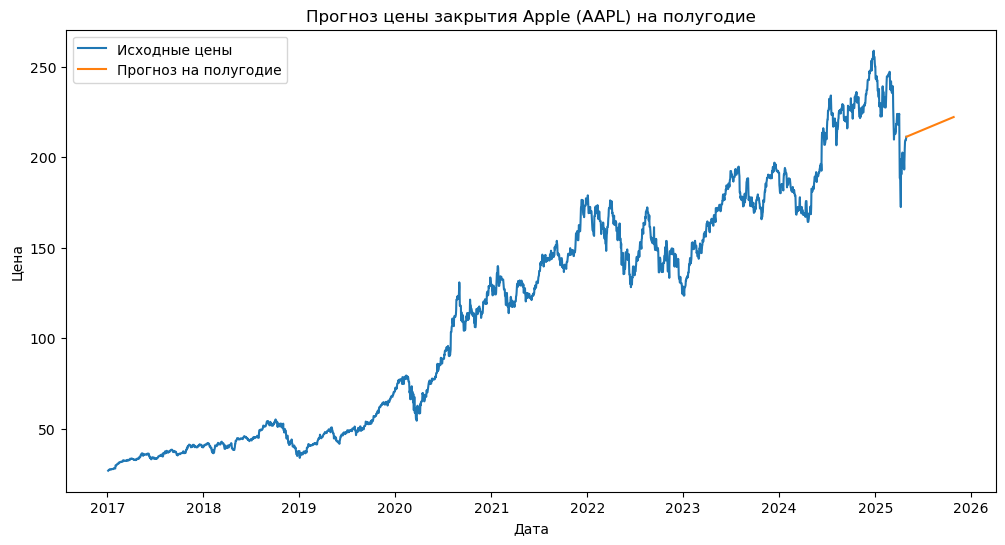

Прогноз цены закрытия Apple (AAPL) на полугодие:
2025-04-30    211.270607
2025-05-01    211.331207
2025-05-02    211.391807
2025-05-03    211.452408
2025-05-04    211.513008
                 ...    
2025-10-22    221.875647
2025-10-23    221.936247
2025-10-24    221.996847
2025-10-25    222.057447
2025-10-26    222.118048
Name: predicted_mean, Length: 180, dtype: float64


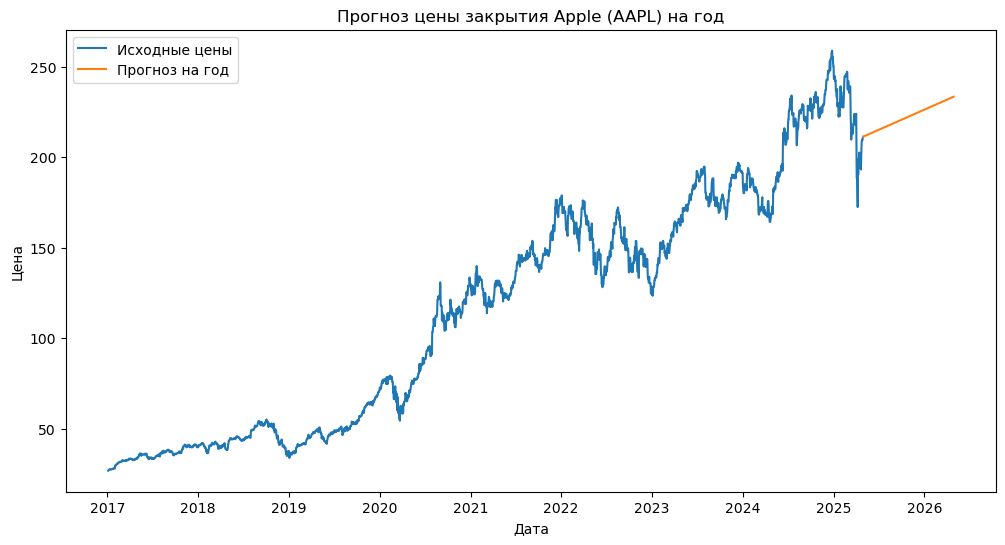

Прогноз цены закрытия Apple (AAPL) на год:
2025-04-30    211.270607
2025-05-01    211.331207
2025-05-02    211.391807
2025-05-03    211.452408
2025-05-04    211.513008
                 ...    
2026-04-25    233.086689
2026-04-26    233.147289
2026-04-27    233.207889
2026-04-28    233.268489
2026-04-29    233.329089
Name: predicted_mean, Length: 365, dtype: float64


In [43]:
# извлекаем цены закрытия акций Apple из датафрейма 
close_prices = data['AAPL'][('Close', 'AAPL')] # Исходные цены закрытия

#  для принятия решений нужно знать прогноз цены, а не ее разности
# чтобы получить прогноз цены, выполним обратное преобразование (интегрирование) прогноза разностей

#  Для каждого горизонта делаем прогноз
for period_name, period_length in horizons.items():
    # Прогнозирование разностей
    forecast_diff = model_fit.forecast(steps=period_length)
''' После получения прогнозов разностей вы выполняем обратное преобразование, начиная с последней известной цены. 
Функция np.cumsum накапливает разности, чтобы получить прогнозируемые цены. '''
    # Обратное преобразование (интегрирование)
    # Получаем последнюю известную цену
    last_price = close_prices.iloc[-1]

    # Накапливаем разности, начиная с последней известной цены
    forecast_prices = np.cumsum(forecast_diff) + last_price

    # Визуализируем результаты
    plt.figure(figsize=(12, 6))
    plt.plot(close_prices, label='Исходные цены')

    # Генерируем даты для прогноза
    last_date = close_prices.index[-1]
    forecast_dates = [last_date + datetime.timedelta(days=i) for i in range(1, period_length + 1)]

    # Преобразуем forecast_dates и forecast_prices в Series для графика
    forecast_series = pd.Series(forecast_prices, index=forecast_dates)

    # Рисуем прогноз
    plt.plot(forecast_series, label=f'Прогноз на {period_name}')
    plt.title(f'Прогноз цены закрытия Apple (AAPL) на {period_name}')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()
    # Выводим значения прогноза
    print(f"Прогноз цены закрытия Apple (AAPL) на {period_name}:")
    print(forecast_series)

Анализ и выводы.
На графике мы видим общую тенденцию к росту цены, цикличость, а также прогноз на год, который показывает, как будет увеличиваться цена.
В таблицах подробные прогнозы цен на месяц, квартал, полугодие и год, демонстрирующие очевидную тенденцию повышения цен закрытия и конкретные значения.
На месяц: 2025-04-30  цена составит  211.270607, на 2025-05-29  - прогнозируемая цена  213.028014;
На квартал: 2025-07-28  цена составит  216.664027;
На полугодие: 2025-10-26 прогнозируемая цена  222.118048;
На год: 2026-04-29 предполагается 233.329089

Таким образом, модель ARIMA может эффективно прогнозировать цены акций Apple. Кроме того, рекомендуется следить за изменениями в трендах и учитывать внешние факторы, такие как новости,  экономические события и политические события.